In [1]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset, ClassLabel
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 从 CSV 加载数据
#data_files = {"data": "../datasets/datasets.csv"}
data_files = {"data": "../datasets/resampled_output.csv"}
dataset = load_dataset("csv", data_files=data_files)

# 将标签中的 . 替换为 _
def replace_dot_with_underscore(example):
    return {"label": example["label"].replace(".", "_")}
dataset = dataset.map(replace_dot_with_underscore)

# 获取唯一的标签值
unique_labels = sorted(set(dataset["data"]["label"]))
print("唯一的标签值:", unique_labels)

# 将 label 列转换为 ClassLabel 类型
dataset = dataset.cast_column("label", ClassLabel(names=unique_labels))

# 打印数据集信息
print(dataset)


c:\Users\DreamDreamer\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
唯一的标签值: ['cs_AI', 'cs_CE', 'cs_DS', 'cs_IT', 'cs_NE', 'cs_PL', 'cs_SY', 'cs_cv', 'math_AC', 'math_GR', 'math_ST']
DatasetDict({
    data: Dataset({
        features: ['review_id', 'keywords', 'keysentences', 'abstract', 'label'],
        num_rows: 16409
    })
})


In [2]:
# 将 keywords、keysentences 和 abstract 拼接成 text
def concatenate_text(example):
    text = ' '.join([str(example['keywords']), str(example['keysentences']), str(example['abstract'])])
    return {'text': text}
dataset = dataset.map(concatenate_text)

# 划分训练集和验证集，80%训练，20%验证
dataset = dataset['data'].train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']

# 获取分类个数
num_classes = len(train_dataset.features['label'].names)
print(f"Number of classes: {num_classes}")

# 加载预训练的 BERT 模型和 tokenizer
model_name = 'bert-base-uncased'  # 或者选择其他适合的 BERT 变体，如 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
model.to(device)

# 数据预处理
def encode_batch(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=512)  # BERT 的最大序列长度为 512

encoded_train_dataset = train_dataset.map(encode_batch, batched=True, batch_size=32)
encoded_eval_dataset = eval_dataset.map(encode_batch, batched=True, batch_size=32)

Number of classes: 11


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 3282/3282 [00:28<00:00, 113.42 examples/s]


In [8]:
# 设置参数，用 Trainer() 创建实例
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=5e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=16,  # 根据 GPU 内存调整
    per_device_eval_batch_size=16,
    warmup_steps=500,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    save_strategy='epoch',  # 保存策略
    load_best_model_at_end=True,  # 在训练结束时加载最好的模型
    metric_for_best_model='macro_f1',  # 用于选择最好的模型的指标
)

# 定义 compute_metrics 函数
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {"accuracy": acc, "macro_f1": macro_f1}

# 创建 Trainer 实例
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


C:\Users\DreamDreamer\AppData\Local\Temp\ipykernel_1704\3143479391.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
# 训练模型
trainer.train()

 20%|██        | 500/2463 [18:17<1:07:42,  2.07s/it]

{'loss': 1.4253, 'grad_norm': 7.183369159698486, 'learning_rate': 5e-05, 'epoch': 0.61}


                                                    
 33%|███▎      | 821/2463 [31:47<47:10,  1.72s/it]

{'eval_loss': 0.8249828815460205, 'eval_accuracy': 0.7434491163924436, 'eval_macro_f1': 0.7413114564974592, 'eval_runtime': 132.9317, 'eval_samples_per_second': 24.689, 'eval_steps_per_second': 1.55, 'epoch': 1.0}


 41%|████      | 1000/2463 [38:09<49:48,  2.04s/it]  

{'loss': 0.7371, 'grad_norm': 15.931988716125488, 'learning_rate': 3.7264391237901174e-05, 'epoch': 1.22}


 61%|██████    | 1500/2463 [55:40<34:57,  2.18s/it]

{'loss': 0.5812, 'grad_norm': 5.5044355392456055, 'learning_rate': 2.4528782475802346e-05, 'epoch': 1.83}


                                                     
 67%|██████▋   | 1642/2463 [1:02:48<23:54,  1.75s/it]

{'eval_loss': 0.6481996178627014, 'eval_accuracy': 0.7940280316879951, 'eval_macro_f1': 0.7877517313080505, 'eval_runtime': 128.5324, 'eval_samples_per_second': 25.534, 'eval_steps_per_second': 1.603, 'epoch': 2.0}


 81%|████████  | 2000/2463 [1:15:08<16:05,  2.08s/it]  

{'loss': 0.4348, 'grad_norm': 14.694954872131348, 'learning_rate': 1.1793173713703516e-05, 'epoch': 2.44}


                                                     
100%|██████████| 2463/2463 [1:32:53<00:00,  1.59s/it]

{'eval_loss': 0.6205015778541565, 'eval_accuracy': 0.812004875076173, 'eval_macro_f1': 0.8074366500598456, 'eval_runtime': 128.1576, 'eval_samples_per_second': 25.609, 'eval_steps_per_second': 1.607, 'epoch': 3.0}


100%|██████████| 2463/2463 [1:32:59<00:00,  2.27s/it]

{'train_runtime': 5579.4421, 'train_samples_per_second': 7.058, 'train_steps_per_second': 0.441, 'train_loss': 0.7189866692081874, 'epoch': 3.0}


TrainOutput(global_step=2463, training_loss=0.7189866692081874, metrics={'train_runtime': 5579.4421, 'train_samples_per_second': 7.058, 'train_steps_per_second': 0.441, 'total_flos': 1.0383464348193792e+16, 'train_loss': 0.7189866692081874, 'epoch': 3.0})

In [11]:
# 评估模型
results = trainer.evaluate()
print("Evaluation Results:", results)

# 获取预测结果
predictions = trainer.predict(encoded_eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

100%|██████████| 206/206 [02:13<00:00,  1.55it/s]


Evaluation Results: {'eval_loss': 0.6205015778541565, 'eval_accuracy': 0.812004875076173, 'eval_macro_f1': 0.8074366500598456, 'eval_runtime': 134.0079, 'eval_samples_per_second': 24.491, 'eval_steps_per_second': 1.537, 'epoch': 3.0}


100%|██████████| 206/206 [02:13<00:00,  1.54it/s]


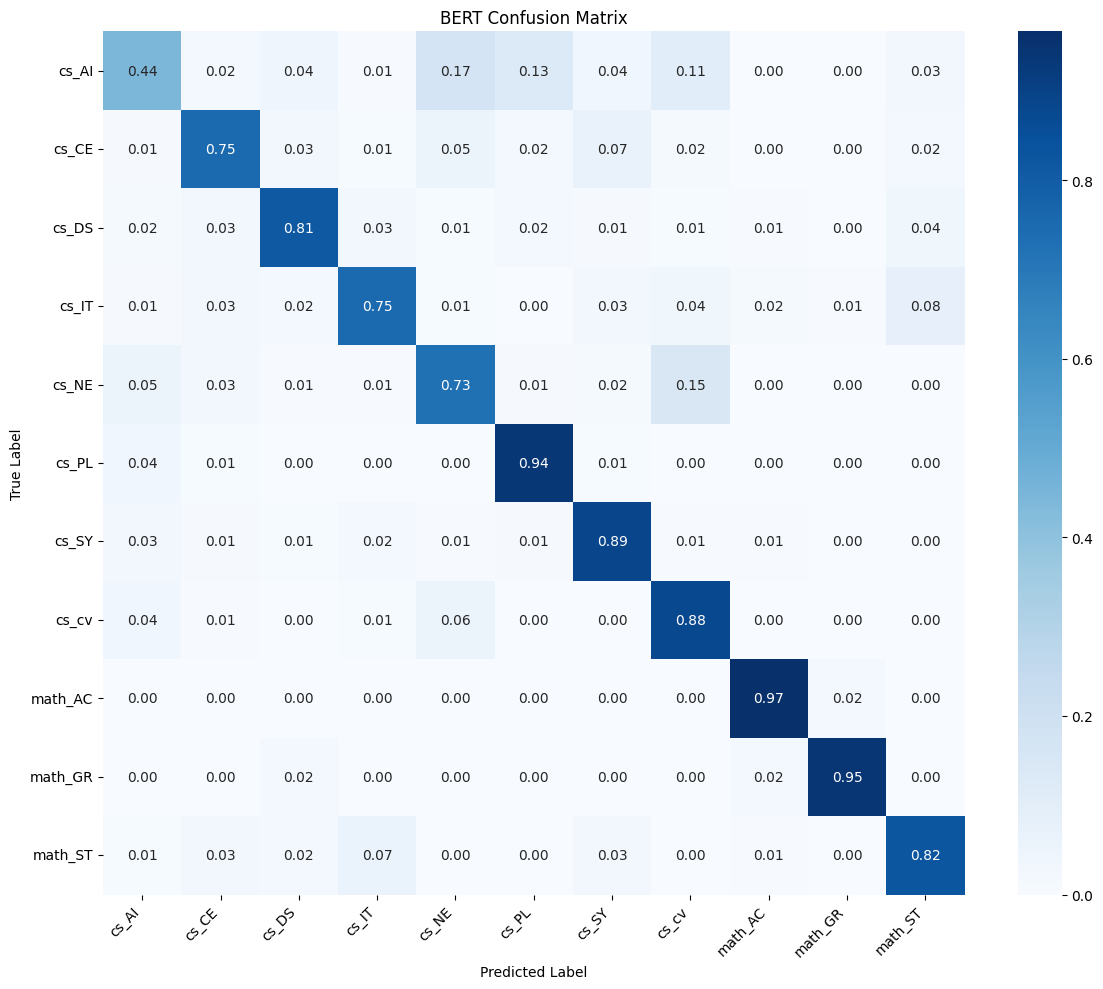

In [12]:
# 计算混淆矩阵
cm = confusion_matrix(labels, preds)
cm_normalized = confusion_matrix(labels, preds, normalize='true')

# 获取标签名称
label_names = unique_labels

# 绘制混淆矩阵
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=label_names, yticklabels=label_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('BERT Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('./results/(test)BERT Confusion Matrix.pdf')
plt.savefig('./results/BERT_Confusion_Matrix.pdf')
plt.show()



In [13]:
# 计算并打印 Macro F1
macro_f1 = f1_score(labels, preds, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

report = classification_report(labels, preds, target_names=label_names, output_dict=True)  # 使用 output_dict=True 生成字典
print("\nClassification Report:")
print(report)

# 转换分类报告为 DataFrame
df_report = pd.DataFrame(report).transpose()

# 添加 Macro F1 到分类报告
df_report.loc['macro_f1'] = {'precision': None, 'recall': None, 'f1-score': macro_f1, 'support': None}

# 指定 CSV 文件路径
#output_csv_path = './results/(test)BERT_classification_report.csv'
output_csv_path = './results/BERT_classification_report.csv'

# 保存为 CSV 文件
df_report.to_csv(output_csv_path, index=True)
print(f"Classification report has been saved to {output_csv_path}")

Macro F1 Score: 0.8074

Classification Report:
{'cs_AI': {'precision': 0.6785714285714286, 'recall': 0.44333333333333336, 'f1-score': 0.5362903225806451, 'support': 300.0}, 'cs_CE': {'precision': 0.8057553956834532, 'recall': 0.7542087542087542, 'f1-score': 0.7791304347826087, 'support': 297.0}, 'cs_DS': {'precision': 0.8327645051194539, 'recall': 0.8133333333333334, 'f1-score': 0.8229342327150084, 'support': 300.0}, 'cs_IT': {'precision': 0.8327137546468402, 'recall': 0.7542087542087542, 'f1-score': 0.7915194346289752, 'support': 297.0}, 'cs_NE': {'precision': 0.6964856230031949, 'recall': 0.7266666666666667, 'f1-score': 0.7112561174551386, 'support': 300.0}, 'cs_PL': {'precision': 0.813953488372093, 'recall': 0.9395973154362416, 'f1-score': 0.8722741433021807, 'support': 298.0}, 'cs_SY': {'precision': 0.8098159509202454, 'recall': 0.8888888888888888, 'f1-score': 0.8475120385232745, 'support': 297.0}, 'cs_cv': {'precision': 0.721763085399449, 'recall': 0.8791946308724832, 'f1-score': 

C:\Users\DreamDreamer\AppData\Local\Temp\ipykernel_1704\3495892777.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_report.loc['macro_f1'] = {'precision': None, 'recall': None, 'f1-score': macro_f1, 'support': None}
